<a href="https://colab.research.google.com/github/SalamUddin844/Deep-Fake-Image-Detection-Using-Deep-Learning-To-Predict-Online-Rumor/blob/main/Real_and_Fake_Image_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, MaxPooling2D, BatchNormalization,Input
from keras.models import Model
from keras.applications import MobileNetV2,VGG19,Xception
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import keras.utils as image
import seaborn as sns
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.image as mpimg
from PIL import Image
import shutil
!pip install tabulate
from skimage import io, color, exposure, measure
import cv2
from tabulate import tabulate

sns.set()
%matplotlib inline
!pip install flask

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/realfale.zip

Archive:  /content/drive/MyDrive/Colab_Notebooks/realfale.zip
  inflating: realfale/app.py         
  inflating: realfale/ensemble_model.h5  
   creating: realfale/static/
 extracting: realfale/static/info.md  
  inflating: realfale/static/javascript.js  
  inflating: realfale/static/style.css  
   creating: realfale/static/uploads/
  inflating: realfale/static/uploads/16.jpg  
  inflating: realfale/static/uploads/18.jpg  
  inflating: realfale/static/uploads/2.jpg  
  inflating: realfale/static/uploads/20.jpg  
  inflating: realfale/static/uploads/21.jpg  
  inflating: realfale/static/uploads/25.jpg  
  inflating: realfale/static/uploads/3.jpeg  
  inflating: realfale/static/uploads/40.jpg  
  inflating: realfale/static/uploads/5.jpg  
  inflating: realfale/static/uploads/50.jpg  
  inflating: realfale/static/uploads/6.jpg  
  inflating: realfale/static/uploads/94887710_2576679499241513_5667889072891232256_n.jpg  
  inflating: realfale/static/uploads/ai1.jpg  
  inflating: realfale/st

In [ ]:
dir= '/content/Dataset/train'

# **Data Distribution**

In [ ]:
class_labels = os.listdir(dir)
image_counts = [len(os.listdir(os.path.join(dir, label))) for label in class_labels]
plt.figure(figsize=(8,5))
sns.barplot(x=class_labels, y=image_counts, palette="viridis")
plt.title('Data Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


FileNotFoundError: ignored

# **Image Visualization**

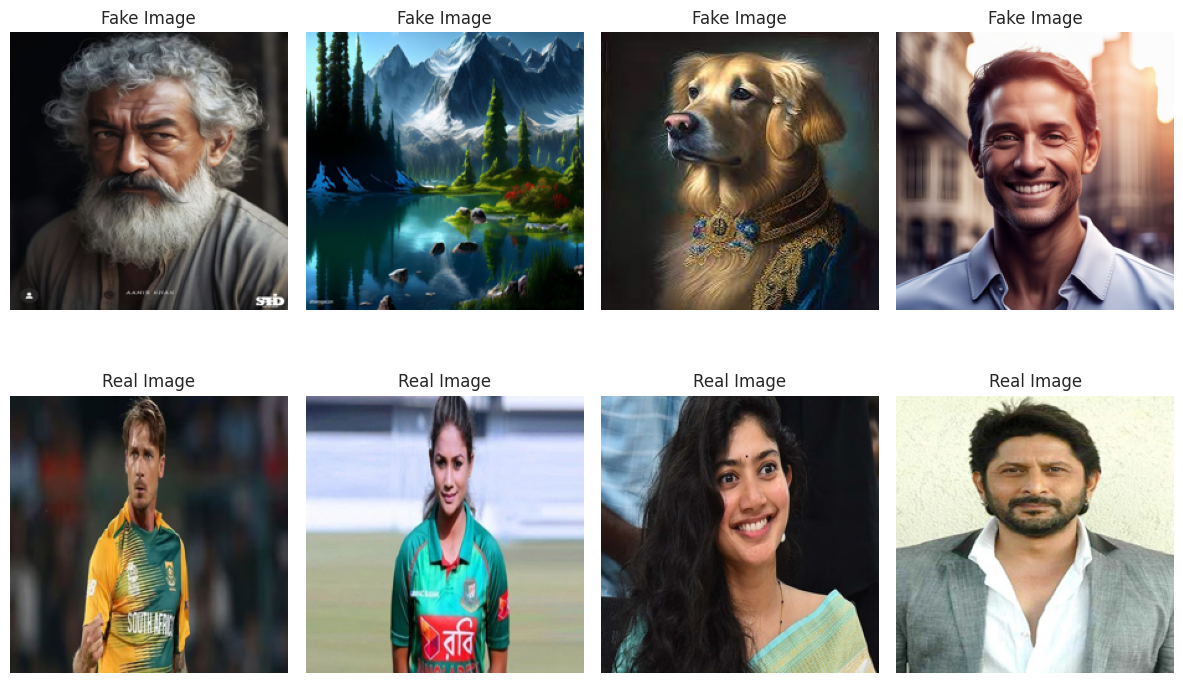

In [ ]:
fake_image_path = os.path.join(dir, "Fake Image")
real_image_path = os.path.join(dir, "Real Image")
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
class_labels = ["Fake Image", "Real Image"]
for i, folder in enumerate([fake_image_path,real_image_path]):
    images = os.listdir(folder)
    for j in range(4):
        img_path = os.path.join(folder, images[j])
        img = Image.open(img_path)
        img = img.resize((224, 224))
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(class_labels[i])
plt.tight_layout()
plt.show()


# **Data Augmentation**

# **Train Set**

In [ ]:
train_datagen=ImageDataGenerator(
   rescale=1./255, #0-1
    zoom_range=0.2,
    shear_range = 0.1,
    horizontal_flip=True,
    rotation_range=(10),
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.5,1.8),

)

In [ ]:
train_generator=train_datagen.flow_from_directory(
    '/content/Dataset/train',
    target_size=(224,224),
    batch_size=10,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)
train_generator.class_indices

Found 83 images belonging to 2 classes.


{'Fake Image': 0, 'Real Image': 1}

# **Test Set**

In [ ]:
test_datagen=ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    shear_range = 0.1,
    horizontal_flip=True,
    rotation_range=(10),
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.5,1.8),
)

In [ ]:
test_generator=train_datagen.flow_from_directory(
    '/content/Dataset/test',
    target_size=(224,224),
    batch_size=10,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,

)
test_generator.class_indices

Found 17 images belonging to 2 classes.


{'Fake Image': 0, 'Real Image': 1}

# **Validation set**

In [ ]:
validation_datagen=ImageDataGenerator(rescale= 1./255)
validation_generator=validation_datagen.flow_from_directory(
    '/content/Dataset/test',
    target_size=(224,224),
    batch_size=10,
    class_mode='binary',
    color_mode='rgb',
)
validation_generator.class_indices


Found 17 images belonging to 2 classes.


{'Fake Image': 0, 'Real Image': 1}

# **Model Architecture**

# **Model_1,DenseNet169**

In [ ]:
from keras.applications.densenet import DenseNet169
dn69=DenseNet169(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in dn69.layers:
    layer.trainable=False
x=dn69.output
x= Conv2D(filters=64,kernel_size=(3,3),activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x=Flatten()(x)
x = Dense(256, activation= 'relu')(x)
x=Dropout(0.2)(x)
prediction=Dense(1,activation='sigmoid')(x)
model_11=Model(inputs=dn69.input,outputs=prediction)
model_11.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_11.summary()

51877672/51877672 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

# **Model Train**

In [ ]:
history_1=model_11.fit(train_generator,validation_data=validation_generator,epochs=15)

Epoch 1/15
9/9 [==============================] - 3s 289ms/step - loss: 0.0425 - accuracy: 0.9880 - val_loss: 0.8470 - val_accuracy: 0.8824
Epoch 2/15
9/9 [==============================] - 3s 293ms/step - loss: 0.1340 - accuracy: 0.9759 - val_loss: 0.4240 - val_accuracy: 0.8824
Epoch 3/15
9/9 [==============================] - 3s 293ms/step - loss: 0.0466 - accuracy: 0.9759 - val_loss: 0.9351 - val_accuracy: 0.8824
Epoch 4/15
9/9 [==============================] - 3s 296ms/step - loss: 0.0164 - accuracy: 0.9880 - val_loss: 1.0880 - val_accuracy: 0.8824
Epoch 5/15
9/9 [==============================] - 4s 456ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.8904 - val_accuracy: 0.8824
Epoch 6/15
9/9 [==============================] - 3s 297ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.4364 - val_accuracy: 0.8824
Epoch 7/15
9/9 [==============================] - 3s 293ms/step - loss: 0.0376 - accuracy: 0.9880 - val_loss: 0.7400 - val_accuracy: 0.8824
Epoch 8/15
9/9 [====

# **Model Save**

In [ ]:
model_11.save("/content/drive/MyDrive/Colab_Notebooks/RealFake/model_11.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Training ,Validation accuracy and loss visualization**

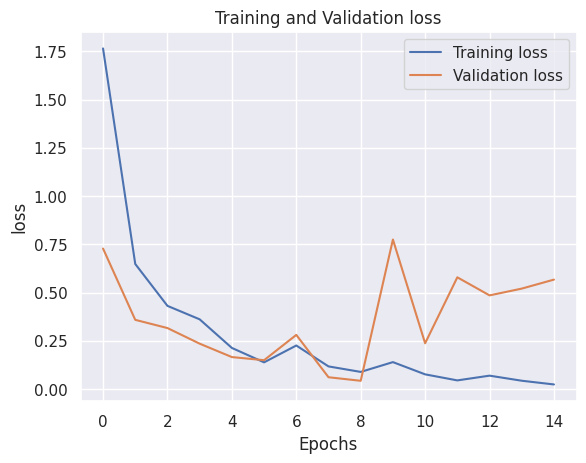

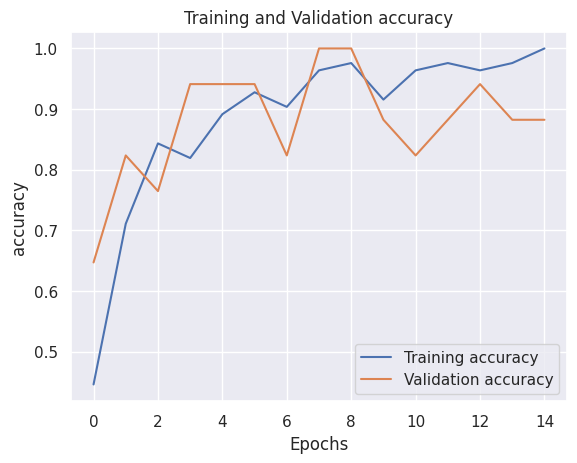

In [ ]:
def plot_metrics(history, metric):
    plt.plot(history_1.history[metric], label='Training ' + metric)
    plt.plot(history_1.history['val_' + metric], label='Validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title('Training and Validation ' + metric)
    plt.legend()
    plt.show()
plot_metrics(history_1, 'loss')
plot_metrics(history_1, 'accuracy')

# **Model Evalution**

In [ ]:
train_loss, train_accuracy = model_11.evaluate(train_generator)
validation_loss, validation_accuracy = model_11.evaluate(validation_generator)
test_loss, test_accuracy = model_11.evaluate(test_generator)

print('\n' + '-'*40 + '\n' + '-'*40)
print(f"{'Train Loss:':<20} {train_loss}")
print(f"{'Train Accuracy:':<20} {train_accuracy}")
print('\n' + '-'*40 + '\n' + '-'*40)
print(f"{'Validation Loss:':<20} {validation_loss}")
print(f"{'Validation Accuracy:':<20} {validation_accuracy}")
print('\n' + '-'*40 + '\n' + '-'*40)
print(f"{'Test Loss:':<20} {test_loss}")
print(f"{'Test Accuracy:':<20} {test_accuracy}")

2/2 [==============================] - 1s 148ms/step - loss: 0.7675 - accuracy: 0.8235

----------------------------------------
----------------------------------------
Train Loss:          0.03367957845330238
Train Accuracy:      0.9879518151283264

----------------------------------------
----------------------------------------
Validation Loss:     0.5670819878578186
Validation Accuracy: 0.8823529481887817

----------------------------------------
----------------------------------------
Test Loss:           0.7675439119338989
Test Accuracy:       0.8235294222831726


# **Output Prediction**

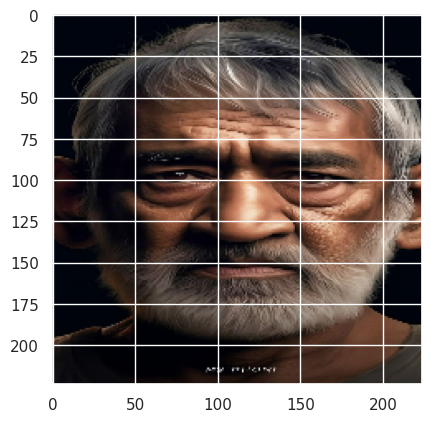

1/1 [==============================] - 4s 4s/step
Fake Image


In [ ]:
img_path = '/content/Dataset/test/Fake Image/3.jpeg'
img = image.load_img(img_path, target_size=(224, 224, 3))
plt.imshow(img, cmap='gray')
plt.show()
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.
pred = model_11.predict(img)
if pred > 0.5:
    print("Real Image")
else:
    print("Fake Image")

# **Properties calculation and tablar representation**

In [ ]:
img = io.imread(img_path)
gray_img = color.rgb2gray(img)
mean_value = round(np.mean(gray_img), 2)
std_dev = round(np.std(gray_img), 2)
rms = round(np.sqrt(np.mean(np.square(gray_img))), 2)
variance = round(np.var(gray_img), 2)
smoothness = round(1 - (1 / (1 + variance)), 2)
num_pixels = gray_img.size
pixel_rate = num_pixels / (img.shape[0] * img.shape[1])
hsv_img = color.rgb2hsv(img)
hue = round(np.mean(hsv_img[:,:,0]), 2)
saturation = round(np.mean(hsv_img[:,:,1]), 2)
contrast = round((np.max(gray_img) - np.min(gray_img)) / (np.max(gray_img) + np.min(gray_img)), 2)
ambiance = round(np.mean(gray_img), 2)
brightness = round((np.max(gray_img) + np.min(gray_img)) / 2, 2)
noise = np.std(gray_img)
signal = np.mean(gray_img)
snr = round(20 * np.log10(signal / noise), 2)
print(' ')
print('Tabular Representation of Image Properties')
array = [
    ["Property", "Value"],
    ["Mean", mean_value],
    ["Standard Deviation", std_dev],
    ["Root Mean Square (RMS)", rms],
    ["Variance", variance],
    ["Smoothness", smoothness],
    ["Number of Pixels", num_pixels],
    ["Pixel Rate", pixel_rate],
    ["Hue", hue],
    ["Saturation", saturation],
    ["Contrast", contrast],
    ["Ambiance", ambiance],
    ["Brightness", brightness],
    ["Signal-to-Noise Ratio (SNR)", snr]
]
print(tabulate(array, headers="firstrow", tablefmt="grid"))

 
Tabular Representation of Image Properties
+-----------------------------+-----------+
| Property                    |     Value |
+=============================+===========+
| Mean                        |      0.23 |
+-----------------------------+-----------+
| Standard Deviation          |      0.21 |
+-----------------------------+-----------+
| Root Mean Square (RMS)      |      0.31 |
+-----------------------------+-----------+
| Variance                    |      0.04 |
+-----------------------------+-----------+
| Smoothness                  |      0.04 |
+-----------------------------+-----------+
| Number of Pixels            | 920880    |
+-----------------------------+-----------+
| Pixel Rate                  |      1    |
+-----------------------------+-----------+
| Hue                         |      0.28 |
+-----------------------------+-----------+
| Saturation                  |      0.48 |
+-----------------------------+-----------+
| Contrast                    |

# **Model_2,VGG19**

In [ ]:

VGG19=VGG19(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in VGG19.layers:
    layer.trainable=False
x=VGG19.output
x= Conv2D(filters=64,kernel_size=(3,3),activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x=Flatten()(x)
x = Dense(256, activation= 'relu')(x)
x=Dropout(0.2)(x)
prediction=Dense(1,activation='sigmoid')(x)
model_22=Model(inputs=VGG19.input,outputs=prediction)
model_22.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_22.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

# **Model Train**

In [ ]:
history_2=model_22.fit(train_generator,validation_data=validation_generator,epochs=15)

Epoch 1/15
9/9 [==============================] - 9s 690ms/step - loss: 0.8016 - accuracy: 0.5542 - val_loss: 0.7015 - val_accuracy: 0.5882
Epoch 2/15
9/9 [==============================] - 3s 294ms/step - loss: 0.6848 - accuracy: 0.5783 - val_loss: 0.5640 - val_accuracy: 0.6471
Epoch 3/15
9/9 [==============================] - 4s 408ms/step - loss: 0.5736 - accuracy: 0.7229 - val_loss: 0.7935 - val_accuracy: 0.7059
Epoch 4/15
9/9 [==============================] - 4s 449ms/step - loss: 0.4331 - accuracy: 0.8313 - val_loss: 0.7484 - val_accuracy: 0.6471
Epoch 5/15
9/9 [==============================] - 3s 316ms/step - loss: 0.4687 - accuracy: 0.8072 - val_loss: 0.5248 - val_accuracy: 0.7647
Epoch 6/15
9/9 [==============================] - 3s 281ms/step - loss: 0.3621 - accuracy: 0.8554 - val_loss: 0.5099 - val_accuracy: 0.7059
Epoch 7/15
9/9 [==============================] - 3s 262ms/step - loss: 0.3838 - accuracy: 0.7831 - val_loss: 1.0344 - val_accuracy: 0.7059
Epoch 8/15
9/9 [====

# **Model Save**

In [ ]:
model_22.save("/content/drive/MyDrive/Colab_Notebooks/RealFake/model_22.h5")

# **Training ,Validation accuracy and loss visualization**


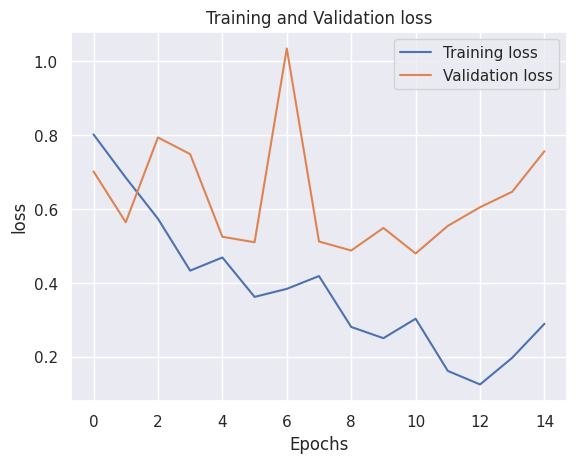

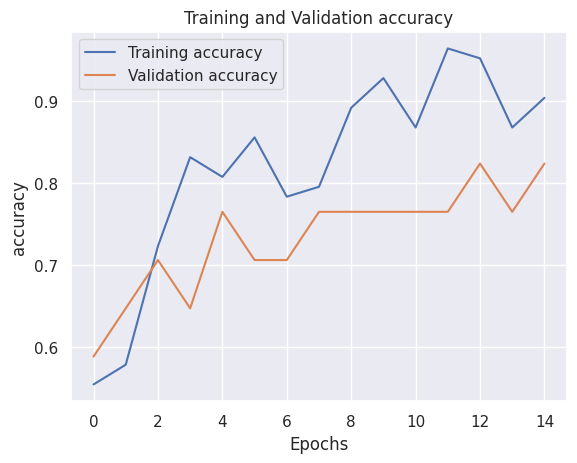

In [ ]:
def plot_metrics(history, metric):
    plt.plot(history_2.history[metric], label='Training ' + metric)
    plt.plot(history_2.history['val_' + metric], label='Validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title('Training and Validation ' + metric)
    plt.legend()
    plt.show()
plot_metrics(history_2, 'loss')
plot_metrics(history_2, 'accuracy')

# **Model Evalution**

In [ ]:
train_loss, train_accuracy = model_22.evaluate(train_generator)
validation_loss, validation_accuracy = model_22.evaluate(validation_generator)
test_loss, test_accuracy = model_22.evaluate(test_generator)

print('\n' + '-'*40 + '\n' + '-'*40)
print(f"{'Train Loss:':<20} {train_loss}")
print(f"{'Train Accuracy:':<20} {train_accuracy}")
print('\n' + '-'*40 + '\n' + '-'*40)
print(f"{'Validation Loss:':<20} {validation_loss}")
print(f"{'Validation Accuracy:':<20} {validation_accuracy}")
print('\n' + '-'*40 + '\n' + '-'*40)
print(f"{'Test Loss:':<20} {test_loss}")
print(f"{'Test Accuracy:':<20} {test_accuracy}")

2/2 [==============================] - 1s 242ms/step - loss: 0.7958 - accuracy: 0.7647

----------------------------------------
----------------------------------------
Train Loss:          0.1564914435148239
Train Accuracy:      0.9397590160369873

----------------------------------------
----------------------------------------
Validation Loss:     0.7564004063606262
Validation Accuracy: 0.8235294222831726

----------------------------------------
----------------------------------------
Test Loss:           0.795806884765625
Test Accuracy:       0.7647058963775635


# **Output Prediction**

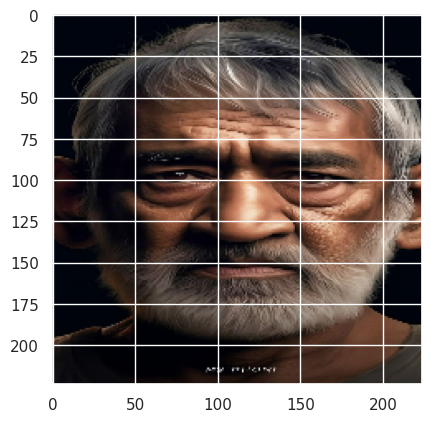

1/1 [==============================] - 1s 761ms/step
Fake Image


In [ ]:
img_path = '/content/Dataset/test/Fake Image/3.jpeg'
img = image.load_img(img_path, target_size=(224, 224, 3))
plt.imshow(img, cmap='gray')
plt.show()
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.
pred = model_22.predict(img)
if pred > 0.5:
    print("Real Image")
else:
    print("Fake Image")

# **Properies Calculation and Tabular representation**

In [ ]:
img = io.imread(img_path)
gray_img = color.rgb2gray(img)
mean_value = round(np.mean(gray_img), 2)
std_dev = round(np.std(gray_img), 2)
rms = round(np.sqrt(np.mean(np.square(gray_img))), 2)
variance = round(np.var(gray_img), 2)
smoothness = round(1 - (1 / (1 + variance)), 2)
num_pixels = gray_img.size
pixel_rate = num_pixels / (img.shape[0] * img.shape[1])
hsv_img = color.rgb2hsv(img)
hue = round(np.mean(hsv_img[:,:,0]), 2)
saturation = round(np.mean(hsv_img[:,:,1]), 2)
contrast = round((np.max(gray_img) - np.min(gray_img)) / (np.max(gray_img) + np.min(gray_img)), 2)
ambiance = round(np.mean(gray_img), 2)
brightness = round((np.max(gray_img) + np.min(gray_img)) / 2, 2)
noise = np.std(gray_img)
signal = np.mean(gray_img)
snr = round(20 * np.log10(signal / noise), 2)
print(' ')
print('Tabular Representation of Image Properties')
array = [
    ["Property", "Value"],
    ["Mean", mean_value],
    ["Standard Deviation", std_dev],
    ["Root Mean Square (RMS)", rms],
    ["Variance", variance],
    ["Smoothness", smoothness],
    ["Number of Pixels", num_pixels],
    ["Pixel Rate", pixel_rate],
    ["Hue", hue],
    ["Saturation", saturation],
    ["Contrast", contrast],
    ["Ambiance", ambiance],
    ["Brightness", brightness],
    ["Signal-to-Noise Ratio (SNR)", snr]
]
print(tabulate(array, headers="firstrow", tablefmt="grid"))

 
Tabular Representation of Image Properties
+-----------------------------+-----------+
| Property                    |     Value |
+=============================+===========+
| Mean                        |      0.23 |
+-----------------------------+-----------+
| Standard Deviation          |      0.21 |
+-----------------------------+-----------+
| Root Mean Square (RMS)      |      0.31 |
+-----------------------------+-----------+
| Variance                    |      0.04 |
+-----------------------------+-----------+
| Smoothness                  |      0.04 |
+-----------------------------+-----------+
| Number of Pixels            | 920880    |
+-----------------------------+-----------+
| Pixel Rate                  |      1    |
+-----------------------------+-----------+
| Hue                         |      0.28 |
+-----------------------------+-----------+
| Saturation                  |      0.48 |
+-----------------------------+-----------+
| Contrast                    |

# **Model_3,ResNet50**

In [ ]:
eff=Xception(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in eff.layers:
    layer.trainable=False
x=eff.output
x= Conv2D(filters=64,kernel_size=(3,3),activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x=Flatten()(x)
x = Dense(256, activation= 'relu')(x)
x=Dropout(0.2)(x)
prediction=Dense(1,activation='sigmoid')(x)
model_33=Model(inputs=eff.input,outputs=prediction)
model_33.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_33.summary()

83683744/83683744 [==============================] - 5s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati

# **Model Train**

In [ ]:
history_3=model_33.fit(train_generator,validation_data=validation_generator,epochs=15)

Epoch 1/15
9/9 [==============================] - 9s 473ms/step - loss: 0.9257 - accuracy: 0.6265 - val_loss: 0.5864 - val_accuracy: 0.7647
Epoch 2/15
9/9 [==============================] - 2s 280ms/step - loss: 0.5201 - accuracy: 0.7711 - val_loss: 0.8627 - val_accuracy: 0.8235
Epoch 3/15
9/9 [==============================] - 5s 596ms/step - loss: 0.5362 - accuracy: 0.8193 - val_loss: 0.5872 - val_accuracy: 0.7647
Epoch 4/15
9/9 [==============================] - 3s 294ms/step - loss: 0.4057 - accuracy: 0.7831 - val_loss: 0.5484 - val_accuracy: 0.7059
Epoch 5/15
9/9 [==============================] - 3s 303ms/step - loss: 0.5291 - accuracy: 0.8313 - val_loss: 1.1456 - val_accuracy: 0.8235
Epoch 6/15
9/9 [==============================] - 3s 316ms/step - loss: 0.2065 - accuracy: 0.9277 - val_loss: 0.8944 - val_accuracy: 0.8235
Epoch 7/15
9/9 [==============================] - 3s 335ms/step - loss: 0.2398 - accuracy: 0.8795 - val_loss: 0.4561 - val_accuracy: 0.8235
Epoch 8/15
9/9 [====

# **Model Save**

In [ ]:
model_33.save("/content/drive/MyDrive/Colab_Notebooks/RealFake/model_33.h5")

# **Training ,Validation accuracy and loss visualization**

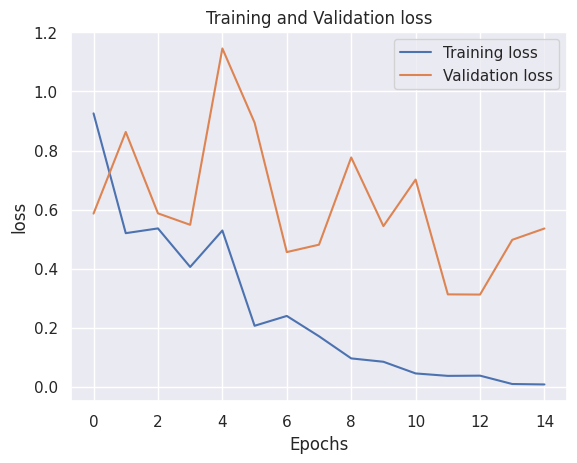

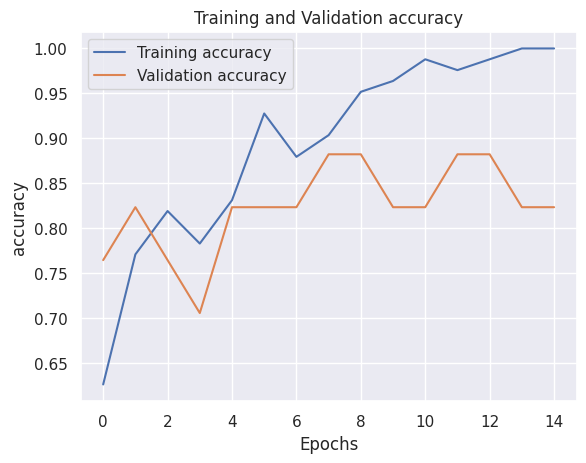

In [ ]:
def plot_metrics(history, metric):
    plt.plot(history_3.history[metric], label='Training ' + metric)
    plt.plot(history_3.history['val_' + metric], label='Validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title('Training and Validation ' + metric)
    plt.legend()
    plt.show()
plot_metrics(history_3, 'loss')
plot_metrics(history_3, 'accuracy')

# **Model Evalution**

In [ ]:
train_loss, train_accuracy = model_33.evaluate(train_generator)
validation_loss, validation_accuracy = model_33.evaluate(validation_generator)
test_loss, test_accuracy = model_33.evaluate(test_generator)

print('\n' + '-'*40 + '\n' + '-'*40)
print(f"{'Train Loss:':<20} {train_loss}")
print(f"{'Train Accuracy:':<20} {train_accuracy}")
print('\n' + '-'*40 + '\n' + '-'*40)
print(f"{'Validation Loss:':<20} {validation_loss}")
print(f"{'Validation Accuracy:':<20} {validation_accuracy}")
print('\n' + '-'*40 + '\n' + '-'*40)
print(f"{'Test Loss:':<20} {test_loss}")
print(f"{'Test Accuracy:':<20} {test_accuracy}")

2/2 [==============================] - 1s 167ms/step - loss: 0.4640 - accuracy: 0.8235

----------------------------------------
----------------------------------------
Train Loss:          0.0025681687984615564
Train Accuracy:      1.0

----------------------------------------
----------------------------------------
Validation Loss:     0.5359446406364441
Validation Accuracy: 0.8235294222831726

----------------------------------------
----------------------------------------
Test Loss:           0.4639876186847687
Test Accuracy:       0.8235294222831726


# **Output Prediction**

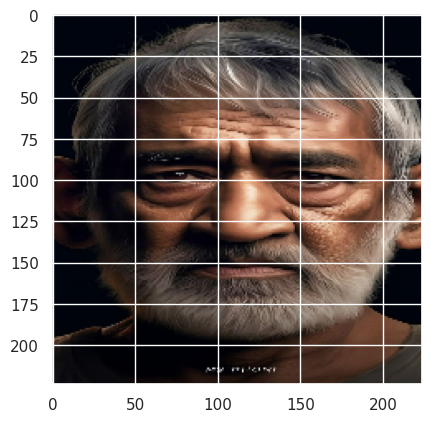

1/1 [==============================] - 1s 1s/step
Fake Image


In [ ]:
img_path = '/content/Dataset/test/Fake Image/3.jpeg'
img = image.load_img(img_path, target_size=(224, 224, 3))
plt.imshow(img, cmap='gray')
plt.show()
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.
pred = model_33.predict(img)
if pred > 0.5:
    print("Real Image")
else:
    print("Fake Image")

# **Properies Calculation and Tabular representation**

In [ ]:
img = io.imread(img_path)
gray_img = color.rgb2gray(img)
mean_value = round(np.mean(gray_img), 2)
std_dev = round(np.std(gray_img), 2)
rms = round(np.sqrt(np.mean(np.square(gray_img))), 2)
variance = round(np.var(gray_img), 2)
smoothness = round(1 - (1 / (1 + variance)), 2)
num_pixels = gray_img.size
pixel_rate = num_pixels / (img.shape[0] * img.shape[1])
hsv_img = color.rgb2hsv(img)
hue = round(np.mean(hsv_img[:,:,0]), 2)
saturation = round(np.mean(hsv_img[:,:,1]), 2)
contrast = round((np.max(gray_img) - np.min(gray_img)) / (np.max(gray_img) + np.min(gray_img)), 2)
ambiance = round(np.mean(gray_img), 2)
brightness = round((np.max(gray_img) + np.min(gray_img)) / 2, 2)
noise = np.std(gray_img)
signal = np.mean(gray_img)
snr = round(20 * np.log10(signal / noise), 2)
print(' ')
print('Tabular Representation of Image Properties')
array = [
    ["Property", "Value"],
    ["Mean", mean_value],
    ["Standard Deviation", std_dev],
    ["Root Mean Square (RMS)", rms],
    ["Variance", variance],
    ["Smoothness", smoothness],
    ["Number of Pixels", num_pixels],
    ["Pixel Rate", pixel_rate],
    ["Hue", hue],
    ["Saturation", saturation],
    ["Contrast", contrast],
    ["Ambiance", ambiance],
    ["Brightness", brightness],
    ["Signal-to-Noise Ratio (SNR)", snr]
]
print(tabulate(array, headers="firstrow", tablefmt="grid"))

 
Tabular Representation of Image Properties
+-----------------------------+-----------+
| Property                    |     Value |
+=============================+===========+
| Mean                        |      0.23 |
+-----------------------------+-----------+
| Standard Deviation          |      0.21 |
+-----------------------------+-----------+
| Root Mean Square (RMS)      |      0.31 |
+-----------------------------+-----------+
| Variance                    |      0.04 |
+-----------------------------+-----------+
| Smoothness                  |      0.04 |
+-----------------------------+-----------+
| Number of Pixels            | 920880    |
+-----------------------------+-----------+
| Pixel Rate                  |      1    |
+-----------------------------+-----------+
| Hue                         |      0.28 |
+-----------------------------+-----------+
| Saturation                  |      0.48 |
+-----------------------------+-----------+
| Contrast                    |

# **Ensemble Model**

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model1 = load_model('/content/drive/MyDrive/Colab_Notebooks/RealFake/model_11.h5')
model1 = Model(inputs=model1.inputs, outputs=model1.outputs, name='DenseNet169')
model2 = load_model('/content/drive/MyDrive/Colab_Notebooks/RealFake/model_22.h5')
model2 = Model(inputs=model2.inputs, outputs=model2.outputs, name='VGG19')
model3 = load_model('/content/drive/MyDrive/Colab_Notebooks/RealFake/model_33.h5')
model3 = Model(inputs=model3.inputs, outputs=model3.outputs, name='ResNet50')
models = [model1, model2, model3]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')
ensemble_model.summary()
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
accuracy = ensemble_model.evaluate(test_generator)
print(f'Ensemble Model Accuracy: {accuracy[1]}')


Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 DenseNet169 (Functional)    (None, 1)                    1366745   ['input_4[0][0]']             
                                                          7                                       
                                                                                                  
 VGG19 (Functional)          (None, 1)                    2038540   ['input_4[0][0]']             
                                                          9                                       
                                                                                           

In [ ]:
ensemble_model.save("/content/drive/MyDrive/Colab_Notebooks/RealFake/ensemble_model.h5")

# **Ensemble Output Prediction With Probability**

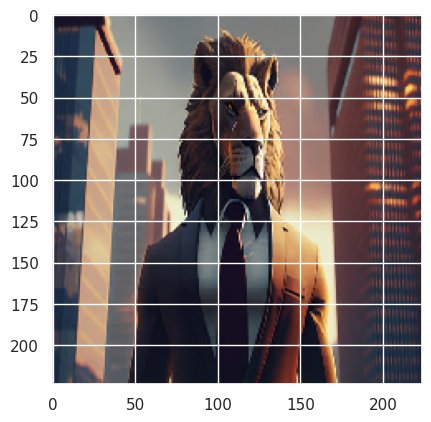

1/1 [==============================] - 4s 4s/step
Fake Image


In [ ]:
img_path = '/content/Dataset/test/Fake Image/21.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img, cmap='gray')
plt.show()
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.
pred = ensemble_model.predict(img)
if pred > 0.5:
    print("Real Image")
else:
    print("Fake Image")


# **Real Image vs Fake Image Properties Comparison**

In [ ]:
import numpy as np
from skimage import io, color
from tabulate import tabulate

real_img_path = "/content/Dataset/test/Real Image/40.jpg"
fake_img_path = "/content/Dataset/test/Fake Image/3.jpeg"

def calculate_properties(img_path):
    img = io.imread(img_path)
    gray_img = color.rgb2gray(img)

    mean_value = round(np.mean(gray_img), 2)
    std_dev = round(np.std(gray_img), 2)
    rms = round(np.sqrt(np.mean(np.square(gray_img))), 2)
    variance = round(np.var(gray_img), 2)
    smoothness = round(1 - (1 / (1 + variance)), 2)
    num_pixels = gray_img.size
    pixel_rate = num_pixels / (img.shape[0] * img.shape[1])

    hsv_img = color.rgb2hsv(img)
    hue = round(np.mean(hsv_img[:,:,0]), 2)
    saturation = round(np.mean(hsv_img[:,:,1]), 2)

    contrast = round((np.max(gray_img) - np.min(gray_img)) / (np.max(gray_img) + np.min(gray_img)), 2)
    ambiance = round(np.mean(gray_img), 2)
    brightness = round((np.max(gray_img) + np.min(gray_img)) / 2, 2)

    noise = np.std(gray_img)
    signal = np.mean(gray_img)
    snr = round(20 * np.log10(signal / noise), 2)

    return [
        ["Property", "Value"],
        ["Mean", mean_value],
        ["Standard Deviation", std_dev],
        ["Root Mean Square (RMS)", rms],
        ["Variance", variance],
        ["Smoothness", smoothness],
        ["Number of Pixels", num_pixels],
        ["Pixel Rate", pixel_rate],
        ["Hue", hue],
        ["Saturation", saturation],
        ["Contrast", contrast],
        ["Ambiance", ambiance],
        ["Brightness", brightness],
        ["Signal-to-Noise Ratio (SNR)", snr]
    ]

real_properties = calculate_properties(real_img_path)
fake_properties = calculate_properties(fake_img_path)

combined_table = [
    ['Property', 'Real Image', 'Fake Image']
]

for i in range(1, len(real_properties)):
    prop_name = real_properties[i][0]
    real_value = real_properties[i][1]
    fake_value = fake_properties[i][1]

    combined_table.append([prop_name, real_value, fake_value])

print('Differences between Real Image and Fake Image Properties')
print(tabulate(combined_table, headers="firstrow", tablefmt="fancy_grid"))

Differences between Real Image and Fake Image Properties
╒═════════════════════════════╤══════════════╤══════════════╕
│ Property                    │   Real Image │   Fake Image │
╞═════════════════════════════╪══════════════╪══════════════╡
│ Mean                        │         0.73 │         0.23 │
├─────────────────────────────┼──────────────┼──────────────┤
│ Standard Deviation          │         0.32 │         0.21 │
├─────────────────────────────┼──────────────┼──────────────┤
│ Root Mean Square (RMS)      │         0.79 │         0.31 │
├─────────────────────────────┼──────────────┼──────────────┤
│ Variance                    │         0.1  │         0.04 │
├─────────────────────────────┼──────────────┼──────────────┤
│ Smoothness                  │         0.09 │         0.04 │
├─────────────────────────────┼──────────────┼──────────────┤
│ Number of Pixels            │    562500    │    920880    │
├─────────────────────────────┼──────────────┼──────────────┤
│ Pixel Rate 

# **Properies visualization**

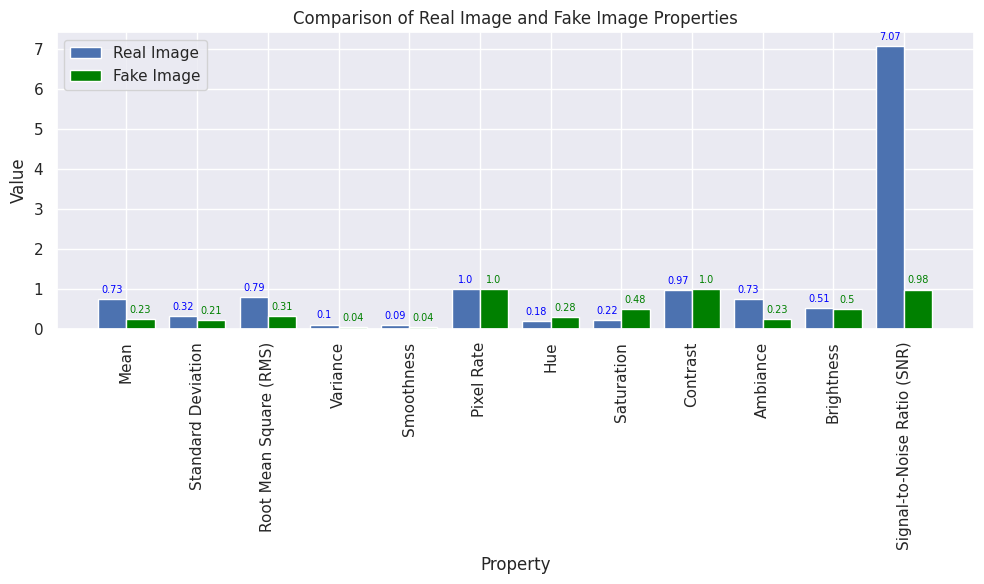

In [ ]:
property_names = [row[0] for row in combined_table[1:] if row[0] != 'Number of Pixels']
real_values = [row[1] for row in combined_table[1:] if row[0] != 'Number of Pixels']
fake_values = [row[2] for row in combined_table[1:] if row[0] != 'Number of Pixels']

y_pos = np.arange(len(property_names))
bar_width = 0.4
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(y_pos, real_values, bar_width, label='Real Image')
rects2 = ax.bar(y_pos + bar_width, fake_values, bar_width, label='Fake Image', color='green')
ax.set_xlabel('Property')
ax.set_ylabel('Value')
ax.set_title('Comparison of Real Image and Fake Image Properties')
ax.set_xticks(y_pos + bar_width / 2)
ax.set_xticklabels(property_names, rotation='vertical')
ax.legend()
for rects, color in zip([rects1, rects2], ['blue', 'green']):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=7,
                    color=color)
plt.tight_layout()
plt.show()
